Load the libraries

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found, model running on CPU")
import tensorflow_addons as tfa
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
tf.random.set_seed(42)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Data Loading and preprocessing

Link dataset in tfrecords: https://drive.google.com/open?id=1sz5MURqR_S_-f4niCx3dYeMXAljowWRt

In [2]:

def record_parser(example, image_size=224):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image.set_shape([image_size, image_size, 3])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename, image_size=224):
  base_path = 'datasets/'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parser = lambda x, size=image_size: record_parser(x, image_size=size)
  parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64

@tf.function
def apply_random_scaling(image, minval=-.02, maxval=.02):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    
    return output, param

def apply_random_shearing(image, minval=-5., maxval=5.):
    #param = tf.random.uniform([], minval=tf.math.atan(minval/image.shape[1]), maxval=tf.math.atan(maxval/image.shape[1]))
    #param = tf.random.uniform([], minval=tf.math.atan(), maxval=tf.math.atan(maxval/image.shape[1]))
    param = np.random.uniform(low=minval, high=maxval)
    output = warp(np.array(image), AffineTransform(shear=np.arctan(param/image.shape[1])).inverse)
    return output, param
@tf.function
def apply_random_rotation(image, minval=-7, maxval=7):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
    return output, param


@tf.function
def apply_tta(image, labels, magnitude=tf.constant(1.0)):
    
    if magnitude <= 0.0:
        return {'x': [image]*10, 'y': [labels]*10, 'method': ['NO_TTA']*10, 'param':[0.0]*10}
    
    scaling_min=-.02*magnitude
    scaling_max=.02*magnitude
    rotation_min=-7*magnitude
    rotation_max=7*magnitude
    augmented_samples = {'x': list(), 'y': list(), 'method': list(), 'param':list()}
    
    output = image
    param = tf.constant(0.0)
    
    # NO-FLIP
    augmented_samples['x'].append(image)
    augmented_samples['y'].append(labels)
    augmented_samples['param'].append(param)
    augmented_samples['method'].append('NOFLIP/ORIGINAL')
        
    # NO-FLIP + ROTATION
    for i in range(1, 3):
        param = tf.random.uniform([], minval=rotation_min, maxval=rotation_max)
        output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('NOFLIP/ROTATION')    
    
    # NO-FLIP + SCALING
    for i in range(1, 3):
        param = tf.random.uniform([], minval=scaling_min, maxval=scaling_max)
        source_size = image.shape
        target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
        output = tf.image.resize_with_crop_or_pad(tf.image.resize(image, target_size), source_size[0], source_size[1])
        
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('NOFLIP/SCALING') 
    
    flip = tf.image.flip_left_right(image)
    param = tf.constant(0.0)
    
    # NO-FLIP
    augmented_samples['x'].append(flip)
    augmented_samples['y'].append(labels)
    augmented_samples['param'].append(param)
    augmented_samples['method'].append('FLIP/ORIGINAL')
        
    # NO-FLIP + ROTATION
    for i in range(1, 3):
        param = tf.random.uniform([], minval=rotation_min, maxval=rotation_max)
        output = tfa.image.rotate(flip, param*math.pi/180.0, interpolation='BILINEAR')
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('FLIP/ROTATION')    
    
    # NO-FLIP + SCALING
    for i in range(1, 3):
        param = tf.random.uniform([], minval=scaling_min, maxval=scaling_max)
        source_size = flip.shape
        target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
        output = tf.image.resize_with_crop_or_pad(tf.image.resize(flip, target_size), source_size[0], source_size[1])
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('FLIP/SCALING') 
    
    return augmented_samples
    
    
def load_dataset_with_tta(filename, image_size=224, tta_magnitude=1.0):
    base_path = 'datasets/'
    full_path = os.path.join(base_path,filename)
    dataset = tf.data.TFRecordDataset(full_path)
    parser = lambda x, size=image_size: record_parser(x, image_size=size)
    parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    custom_tta = lambda x, y: apply_tta(x, y, magnitude=tf.constant(tta_magnitude))
    parsed_dataset = parsed_dataset.map(custom_tta,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    return parsed_dataset



#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

# UNCOMMENT TO ENABLE TRAINING
# train_dataset = make_dataset('conditional_training.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
#test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)



# TODO: Since we cannot convert the full pipeline to tensorflow (due to shearing depending on Skimage), the make tta dataset will:
# 1) Compute the dataset if not already present at the given path (using the classical for structure)
# 2) Load the dataset from npy files as a tensorflow dataset

# Model Training

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201,DenseNet121,DenseNet169
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


def predict(model, input_, apply_bayes):
    predictions = model.predict(input_)
    if apply_bayes:
        return apply_bayes_to_predictions(predictions)
    else:
        return predictions

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/Models320/VGG19'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb,early_stopping]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [ ]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

# Load Models

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=1EkuS27OzYyQ4fqfiNQdcrO6nQkyKBJ9B

# WARNING CONDITIONAL TRAINING IS DISABLED

In [3]:
LOAD_FINETUNED_MODELS = True
ENABLE_BAYES = False
MAGNITUDES = [0.0, 1.0, 1.5, 2.0, 2.5, 5.0]
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
model_names = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

In [4]:
from tensorflow.keras.models import load_model

def load_models(base_path):
      models = []
      model_names = sorted(os.listdir(base_path))
      for model in model_names:
        print('loading model: {}'.format(model))
        models.append(load_model(os.path.join(base_path,model)))
      return models, model_names

if LOAD_FINETUNED_MODELS:
    model_names = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

    models = []
    for el in model_names:
      mod = load_model('ConditionalTraining/{}/FineTuning/model-05.hdf5'.format(el))
      models.append(mod)
else:
    base_path = './Models/'
    models, model_names = load_models(base_path)
    
embedding_models = list()
for model in models:
    x = model.layers[-2].output
    embedding_models.append(tf.keras.Model(inputs=model.input, outputs=x))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: keras_applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


# Model Predictions

In [6]:
# WARNING
# CONDITIONAL TRAINING TEMPRARILY DISABLED FOR CHECKING THE RESULTS WITHOUT BAYES
#ENABLE_CONDITIONAL_TRAINING = False

In [32]:

predictions = [list() for m in MAGNITUDES]
labels = [list() for m in MAGNITUDES]
tta_params = pd.DataFrame(columns=['sample', 'magnitude', 'method', 'param'])

for m, magnitude in enumerate(MAGNITUDES):
    dset = load_dataset_with_tta('test_set_cropped.tfrecords', tta_magnitude=magnitude)
    embeddings = [list() for mod in embedding_models]
    for r, row in enumerate(dset):
        print('\r Magnitude {} Sample {}'.format(m, r), end='')
        pred = list()
        mod_labels = list()
        for mod, (model, embedding_model) in enumerate(zip(models, embedding_models)):
            pred.append(predict(model, row['x'], ENABLE_BAYES))
            mod_labels.append(row['y'].numpy())
            embeddings[mod].append(embedding_model.predict(row['x']))
        predictions[m].append(np.stack(pred))
        labels[m].append(np.stack(mod_labels))
        for method, param in zip(row['method'].numpy(), row['param'].numpy()):
            tta_params = tta_params.append({'sample': r, 'magnitude': magnitude, 'method': method.decode('utf8'), 'param':param}, ignore_index=True)
        
    # Save the embeddings to avoid wasting memory
    for embd, modname in zip(embeddings, model_names):
        np.save('./Predictions/v2/embedding_test/testembed_{}-Magnitude-{}'.format(modname, magnitude), embd)
    
predictions = np.array(predictions).transpose(1, 3, 0, 2, 4) # Shape (Samples, Augmentations, Magnitudes, Models, Labels)
labels = np.array(labels).transpose(1, 3, 0, 2, 4) # Shape (Samples, Augmentations, Magnitudes, Models, Labels)

np.save('./Predictions/v2/test_predictions_tta', predictions)
np.save('./Predictions/v2/test_labels_tta', labels)
tta_params.to_csv('Predictions/v2/tta_params.csv')


 Magnitude 3 Sample 5

In [ ]:
tta_predictions = list()
test_Y = list() # Predictions of shape (dataset_images, labels)
test_Y_tta = list() # Predictions of shape (augmented_images, labels), where augmented_images = 10*dataset_images, samples are grouped for 10 augmentations on the same images (a0,a1,...,a9, b0, b1, b9..)
for augmented_block, label in tta_dataset:
    test_Y.append(label.numpy())
    models_predictions = list()
    for model in models:
        models_predictions.append(np.stack([predict(model, img[tf.newaxis, ...], ENABLE_CONDITIONAL_TRAINING) for img in tf.unstack(augmented_block)]))
    tta_predictions.append(np.stack(models_predictions))
    for augmented_img in range(augmented_block.shape[0]):
            test_Y_tta.append(label)
test_Y = np.array(test_Y) 
test_Y_tta =np.array(test_Y_tta)
tta_predictions = np.stack(tta_predictions).squeeze().transpose(1, 0, 2, 3) # Prediction for each augmented image and model
tta_prediction_means = tta_predictions.mean(axis=2)
tta_predictions = tta_predictions.reshape((tta_predictions.shape[0], tta_predictions.shape[1]*tta_predictions.shape[2], tta_predictions.shape[3]))

In [40]:
predictions = np.load('./Predictions/v2/test_predictions_tta.npy')
labels = np.load('./Predictions/v2/test_labels_tta.npy')
tta_params = pd.read_csv('Predictions/v2/tta_params.csv', index_col=0)

## TTA Robustness

In [26]:
predictions_merged = predictions.reshape((predictions.shape[0], predictions.shape[1]*predictions.shape[2], predictions.shape[3], predictions.shape[4]))

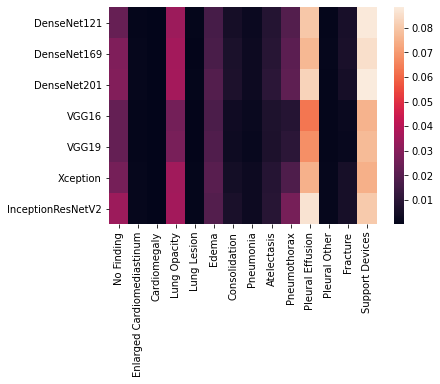

In [55]:
plt.figure(figsize=(30, 5))
varlist = list()
for i, magni_pred in enumerate(predictions_merged):
    varlist.append(np.var(magni_pred, axis=(0)))
varlist = np.stack(varlist)

for i, var in enumerate(varlist):
    robustness = pd.DataFrame(var, columns=dummy_labels, index=model_names)
    plt.subplot(1, len(MAGNITUDES), i+1)
    sns.heatmap(robustness, robust=True, vmin=varlist.min(), vmax=varlist.max())

In [41]:
def apply_bayes_to_predictions(pred):
    bpred = np.copy(pred)
    bpred[...,5] = bpred[...,3] * bpred[...,5]
    bpred[...,6] = bpred[...,3] * bpred[...,6]
    bpred[...,7] = bpred[...,3] * bpred[...,7]
    bpred[...,4] = bpred[...,3] * bpred[...,4]
    bpred[...,8] = bpred[...,3] * bpred[...,8]
    bpred[...,2] = bpred[...,1] * bpred[...,2]
    return bpred

bayes_predictions = apply_bayes_to_predictions(predictions)
#print(np.all(np.equal(bayes_predictions, predictions)))

In [42]:
def single_model_performance(predictions, ground_truth, tta_params=tta_params):
    '''
    predictions: Array-Like of shape (Samples, Augmentations, Magnitudes, Models, Labels)
    ground_truth: Array-Like of shape (Samples, Augmentations, Magnitudes, Models, Labels)
    '''
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # transposing to keep (samples, labels) as last dimensions
    predictions = predictions.transpose(1, 2, 3, 0, 4)
    ground_truth = ground_truth.transpose(1, 2, 3, 0, 4)
    #arams_transposed = tta_params.set_index(['method', 'magnitude'])
    
    titles = model_names
    #fig, c_ax = plt.subplots(2,3, figsize = (15, 10))
    #ig = plt.figure(figsize=(25,14))
    
    results = pd.DataFrame()

    for id_augm, (pred_augm, gt_augm) in enumerate(zip(predictions, ground_truth)):
        for id_magn, (pred_magn, gt_magn) in enumerate(zip(pred_augm, gt_augm)):
            magnitude = tta_params['magnitude'].unique()[id_magn]
            method = tta_params.loc[(tta_params['sample']==0) & (tta_params['magnitude']==magnitude)]['method'].iloc[id_augm]
            for id_model, (pred_model, gt_model) in enumerate(zip(pred_magn, gt_magn)):
                model = model_names[id_model]
                actual_param_variance = tta_params.loc[(tta_params['method']==method) & (tta_params['magnitude']==magnitude)]['param'].var()
                for id_label, label in enumerate(dummy_labels):
                    fpr, tpr, thresholds = roc_curve(gt_model[:,id_label], pred_model[:,id_label])
                    score = auc(fpr, tpr)
                    results = results.append({'method': method, 'magnitude': magnitude, 'model':model, 'param_var':actual_param_variance, 'label': label, 'single_model_auc':score}, ignore_index=True)
    return results

#test_res = plot_single_model_performance(test_predictions), test_Y.pivot(index='Model', columns='Label').to_csv('results/single_model.csv')
#tta_res = plot_single_model_performance(tta_prediction_means, test_Y).pivot(index='Model', columns='Label').to_csv('results/single_model_tta_norm.csv')
#tta_res = plot_single_model_performance(tta_predictions, test_Y_tta).pivot(index='Model', columns='Label').to_csv('results/single_model_tta_nomean.csv')
#test_res_nobayes = plot_single_model_performance(test_predictions,test_Y).pivot(index='Model', columns='Label').to_csv('results/single_model_nobayes.csv')
#tta_res_nobayes = plot_single_model_performance(tta_prediction_means,test_Y).pivot(index='Model', columns='Label').to_csv('results/single_model_tta_nobayes.csv')
perf_singlemodel_v2_nocond = single_model_performance(predictions, labels, tta_params)
perf_singlemodel_v2_nocond['bayes'] = 'no_bayes'

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [43]:
perf_singlemodel_v2_bayes = single_model_performance(bayes_predictions, labels, tta_params)
perf_singlemodel_v2_bayes['bayes'] = 'bayes'

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


## Single Model Performances with and without Bayes

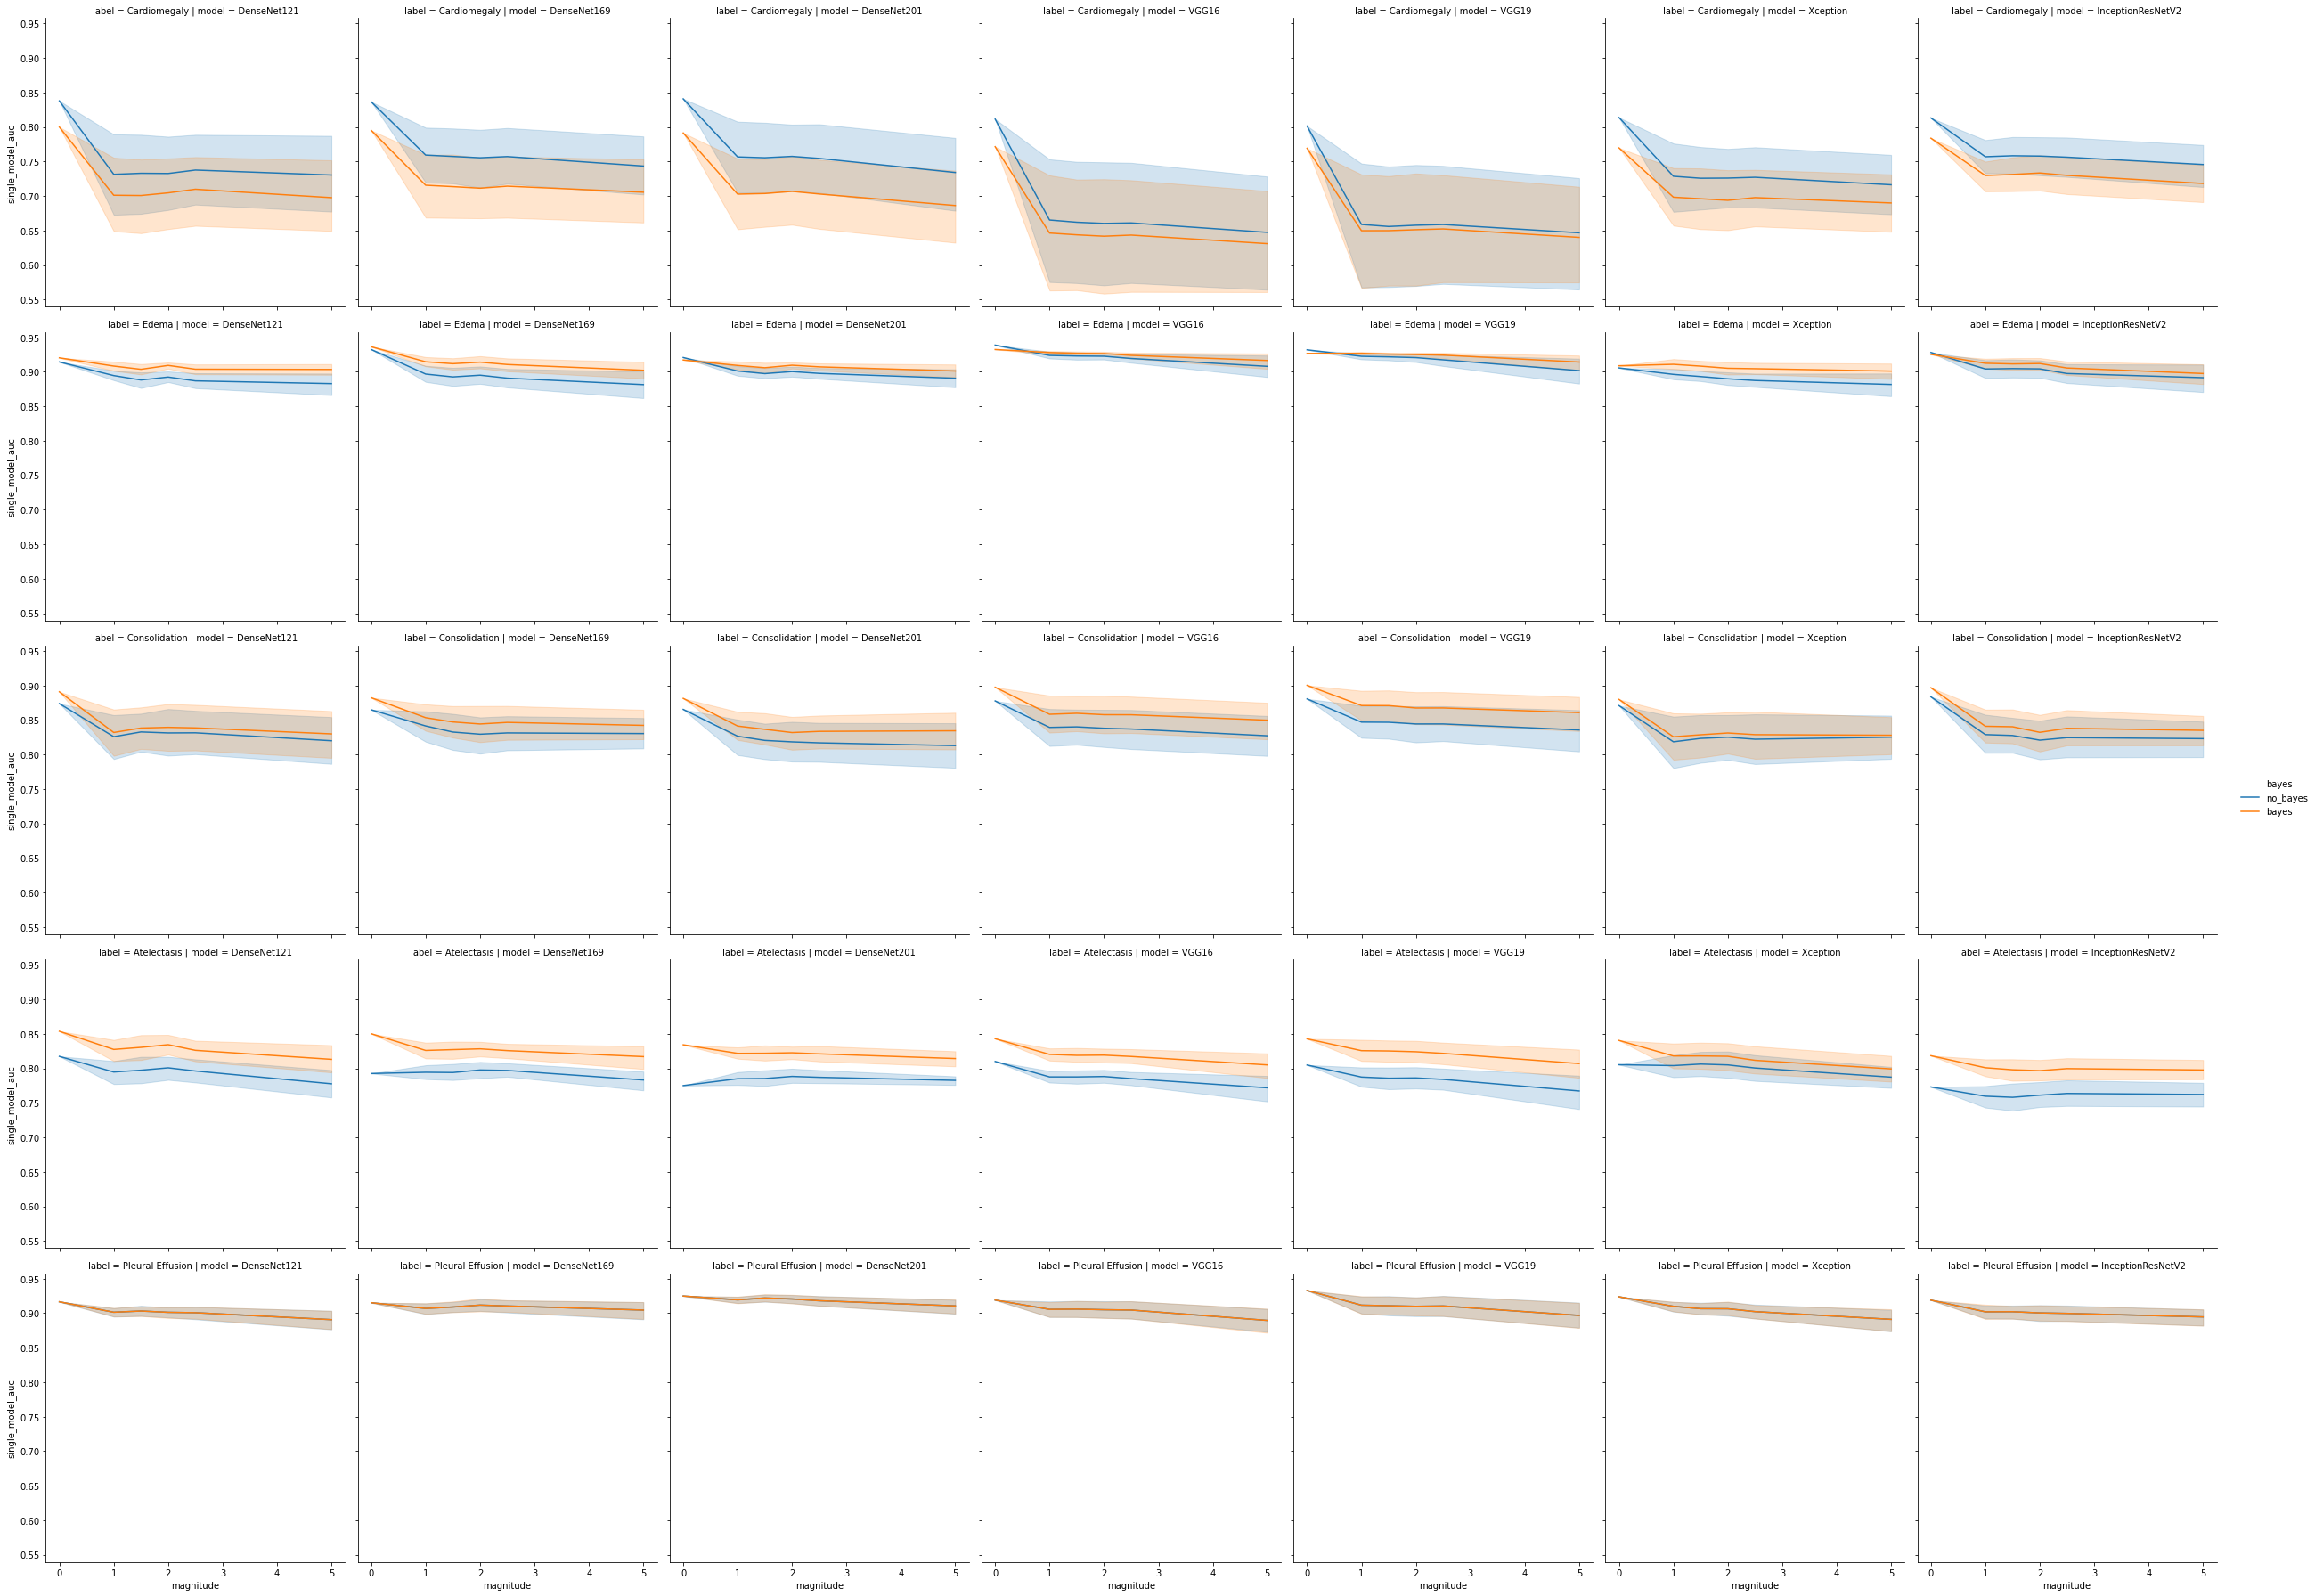

In [44]:
data_to_show = pd.DataFrame()
data_to_show = data_to_show.append(perf_singlemodel_v2_nocond, ignore_index=True)
data_to_show = data_to_show.append(perf_singlemodel_v2_bayes, ignore_index=True)
data_to_show = data_to_show[data_to_show['label'].isin(target_labels)]
p = sns.relplot(data=data_to_show, x='magnitude', y='single_model_auc', col='model', row='label', kind='line', hue='bayes')
# Results have variance due to the grouping in aggregation method

In [45]:
# Merging the (sample, augmentation) dimensions
new_shape = (predictions.shape[0]*predictions.shape[1], predictions.shape[2], predictions.shape[3], predictions.shape[4])
predictions_merged = predictions.reshape(new_shape)
predictions_bayes_merged = bayes_predictions.reshape(new_shape)
labels_merged = labels.reshape(new_shape)

In [46]:
# Single model performance (merged)
def model_predictions_merged(model_predictions, ground_truth, magnitude_values):
    '''
    model_predictions: array-like of shape (samples, magnitude, models, labels)
    ground_truth: array-like of shape (samples, magnitude, models, labels)
    magnitude_values: list of magnitude values, must have the same length of the 2nd axis of predictions and gt
    '''
    
    results = pd.DataFrame()
    model_predictions = model_predictions.transpose(1, 2, 0, 3)
    ground_truth = ground_truth.transpose(1, 2, 0, 3)
    
    for magvalue, pred_magn, gt_magn in zip(magnitude_values, model_predictions, ground_truth):
        for model, modpred, modgt in zip(model_names, pred_magn, gt_magn):
            for id_label, label in enumerate(dummy_labels):
                fpr, tpr, thresholds = roc_curve(modgt[:,id_label], modpred[:,id_label])
                score = auc(fpr, tpr)
                results = results.append({'magnitude': magvalue, 'model':model, 'label': label, 'score':score}, ignore_index=True)
    return results

perf_singlemodel_merged_nobayes = model_predictions_merged(predictions_merged, labels_merged, tta_params['magnitude'].unique())
perf_singlemodel_merged_bayes = model_predictions_merged(predictions_bayes_merged, labels_merged, tta_params['magnitude'].unique())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [47]:
perf_singlemodel_merged_nobayes = perf_singlemodel_merged_nobayes[perf_singlemodel_merged_nobayes['label'].isin(target_labels)]

In [84]:
temp1 = perf_singlemodel_merged_nobayes
temp2 = perf_singlemodel_merged_bayes
temp1['bayes'] = 'no_bayes'
temp2['bayes'] = 'bayes'
tosave = pd.concat([temp1, temp2])
tosave = tosave[tosave['label'].isin(target_labels)]
tosave.to_csv('single_models_v2.csv')

In [83]:
tosave

,label,magnitude,model,score,bayes
2,Cardiomegaly,0.0,DenseNet121,0.837901,no_bayes
5,Edema,0.0,DenseNet121,0.914286,no_bayes
6,Consolidation,0.0,DenseNet121,0.873897,no_bayes
8,Atelectasis,0.0,DenseNet121,0.817428,no_bayes
10,Pleural Effusion,0.0,DenseNet121,0.916553,no_bayes
...,...,...,...,...,...
576,Cardiomegaly,5.0,InceptionResNetV2,0.714766,bayes
579,Edema,5.0,InceptionResNetV2,0.896466,bayes
580,Consolidation,5.0,InceptionResNetV2,0.834954,bayes
582,Atelectasis,5.0,InceptionResNetV2,0.798061,bayes


## Generating Ensembling

In [48]:
from scipy.stats import entropy

def pick_best()
def make_weighted_predictions(predictions, axis=None):
  entropies = entropy([predictions,1-predictions],base = 2)
  return np.average(predictions,axis=axis,weights=1-entropies)

def apply_majority_voting(predictions, axis=None, threshold=0.5):
    binary_pred = predictions >= threshold
    binary_pred = binary_pred.astype(int)
    votes = binary_pred.sum(axis=axis)
    final_pred = votes >=4
    final_pred = final_pred.astype(int)
    return final_pred
    
labels_shrinked = labels_merged.mean(axis=2)
simple_predictions_nobayes = predictions_merged.mean(axis=2)
simple_predictions_bayes = predictions_bayes_merged.mean(axis=2)
weighted_predictions_nobayes = make_weighted_predictions(predictions_merged, axis=2)
weighted_predictions_bayes = make_weighted_predictions(predictions_bayes_merged, axis=2)
voting_predictions_nobayes = apply_majority_voting(predictions_merged, axis=2)
voting_predictions_bayes = apply_majority_voting(predictions_bayes_merged, axis=2)

In [75]:
def aggregated_aurocs(model_predictions, ground_truth, magnitude_values, aggregation_method):
    '''
    model_predictions: array-like of shape (samples, magnitude, labels)
    ground_truth: array-like of shape (samples, magnitude, labels)
    magnitude_values: list of magnitude values, must have the same length of the 2nd axis of predictions and gt
    '''
    
    results = pd.DataFrame()
    model_predictions = model_predictions.transpose(1, 0, 2)
    ground_truth = ground_truth.transpose(1, 0, 2)
    
    for magvalue, pred_magn, gt_magn in zip(magnitude_values, model_predictions, ground_truth):
        for id_label, label in enumerate(dummy_labels):
            fpr, tpr, thresholds = roc_curve(gt_magn[:,id_label], pred_magn[:,id_label])
            score = auc(fpr, tpr)
            results = results.append({'magnitude': magvalue, 'label': label, 'aggregation':aggregation_method, 'score':score}, ignore_index=True)
    return results

data_to_show = pd.DataFrame()

pick_best_nobayes = perf_singlemodel_merged_nobayes.groupby(['magnitude', 'label']).max().drop(columns = ['model']).reset_index()
pick_best_nobayes['aggregation'] = 'pick_best'
pick_best_nobayes['bayes'] = 'no_bayes'
data_to_show = data_to_show.append(pick_best_nobayes, ignore_index=True)
pick_best_bayes = perf_singlemodel_merged_bayes.groupby(['magnitude', 'label']).max().drop(columns = ['model']).reset_index()
pick_best_bayes['aggregation'] = 'pick_best'
pick_best_bayes['bayes'] = 'bayes'
data_to_show = data_to_show.append(pick_best_bayes, ignore_index=True)

perf_simplemean_nobayes = aggregated_aurocs(simple_predictions_nobayes, labels_shrinked, tta_params['magnitude'].unique(), 'simple_mean')
perf_simplemean_nobayes['bayes'] = 'no_bayes'
data_to_show = data_to_show.append(perf_simplemean_nobayes, ignore_index=True)

perf_simplemean_bayes = aggregated_aurocs(simple_predictions_bayes, labels_shrinked, tta_params['magnitude'].unique(), 'simple_mean')
perf_simplemean_bayes['bayes'] = 'bayes'
data_to_show = data_to_show.append(perf_simplemean_bayes, ignore_index=True)

perf_weighted_nobayes = aggregated_aurocs(weighted_predictions_nobayes, labels_shrinked, tta_params['magnitude'].unique(), 'weighted_mean')
perf_weighted_nobayes['bayes'] = 'no_bayes'
data_to_show = data_to_show.append(perf_weighted_nobayes, ignore_index=True)

perf_weighted_bayes = aggregated_aurocs(weighted_predictions_bayes, labels_shrinked, tta_params['magnitude'].unique(), 'weighted_mean')
perf_weighted_bayes['bayes'] = 'bayes'
data_to_show = data_to_show.append(perf_weighted_bayes, ignore_index=True)

perf_voting_nobayes = aggregated_aurocs(voting_predictions_nobayes, labels_shrinked, tta_params['magnitude'].unique(), 'maj_voting')
perf_voting_nobayes['bayes'] = 'no_bayes'
data_to_show = data_to_show.append(perf_voting_nobayes, ignore_index=True)

perf_voting_bayes = aggregated_aurocs(voting_predictions_bayes, labels_shrinked, tta_params['magnitude'].unique(), 'maj_voting')
perf_voting_bayes['bayes'] = 'bayes'
data_to_show = data_to_show.append(perf_voting_bayes, ignore_index=True)

data_to_show = data_to_show[data_to_show['label'].isin(target_labels)]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


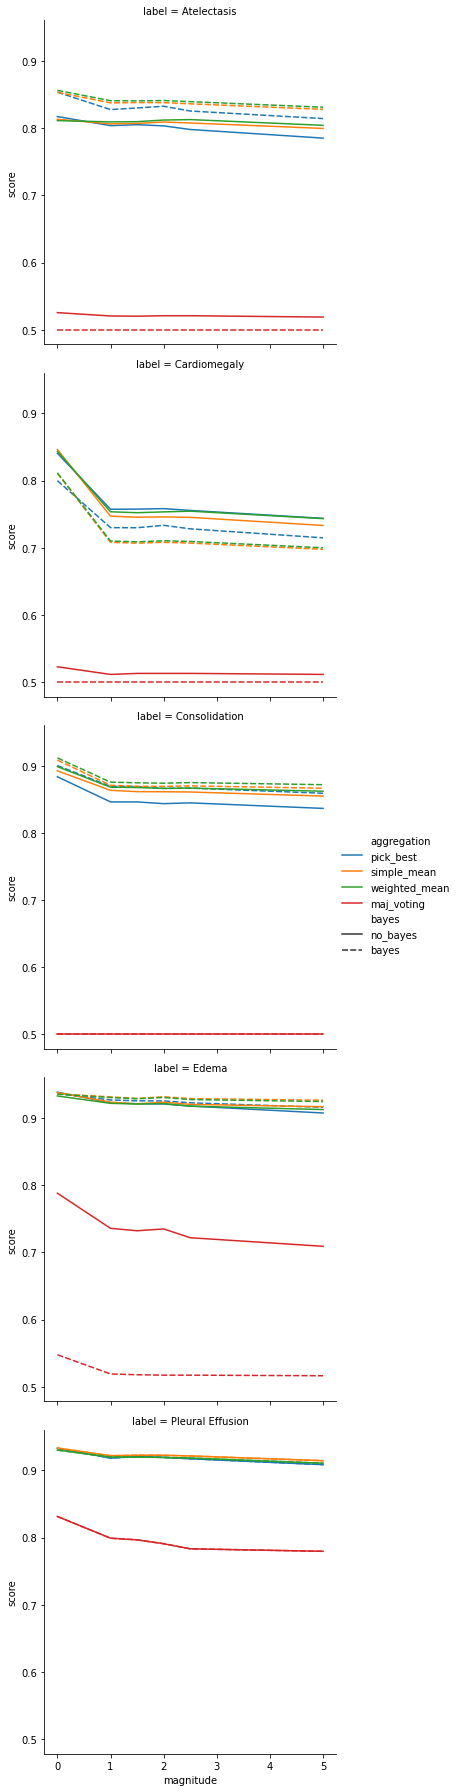

In [79]:
p = sns.relplot(data=data_to_show, x='magnitude', y='score', row='label', kind='line', hue='aggregation', style='bayes')

In [78]:
data_to_show.to_csv('simple_aggregations.csv')

# Majority Voting

Majority voting with threshold 0.5

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

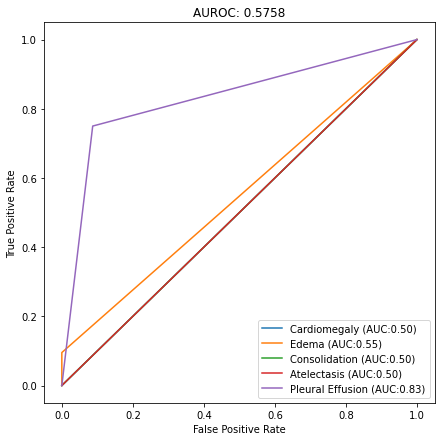

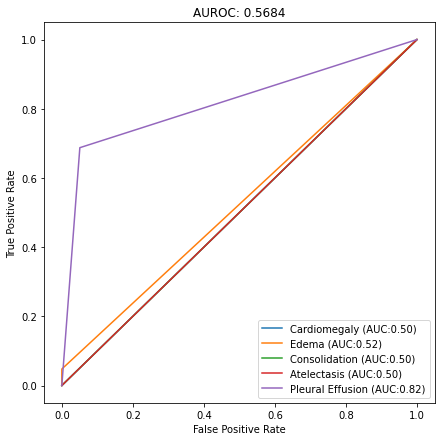

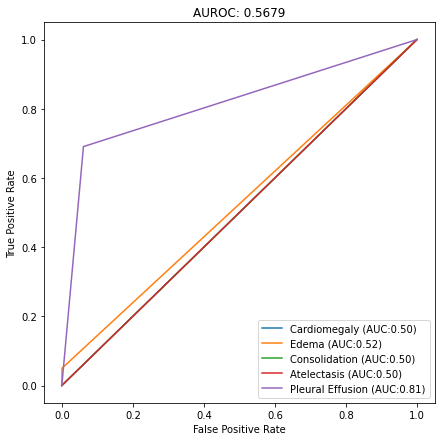

In [48]:
def plot_majority_voting(predictions, ground_truth, threshold=0.5):
    binary_pred = predictions >= threshold
    binary_pred = binary_pred.astype(int)
    votes = binary_pred.sum(axis=0)
    final_pred = votes >=4
    final_pred = final_pred.astype(int)

    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    results = pd.DataFrame()
    aurocs = []
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(ground_truth[:,i].astype(int), final_pred[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(score)
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results
plot_majority_voting(test_predictions, test_Y).to_csv('results/majority_voting.csv')
plot_majority_voting(tta_prediction_means, test_Y).to_csv('results/majority_voting_tta.csv')
plot_majority_voting(tta_predictions, test_Y_tta).to_csv('results/majority_voting_tta_nomeans.csv')

Majority voting with threshold 0.2

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

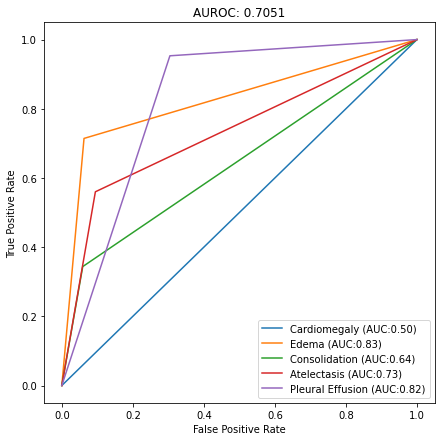

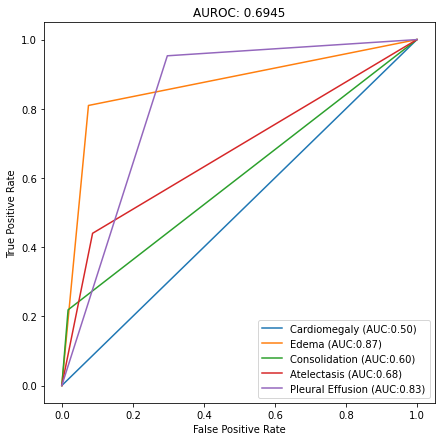

In [14]:
plot_majority_voting(test_predictions, threshold=0.2).to_csv('results/majority_voting_thr0.2.csv')
plot_majority_voting(tta_prediction_means, threshold=0.2).to_csv('results/majority_voting_thr0.2_tta.csv')

# Voting

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

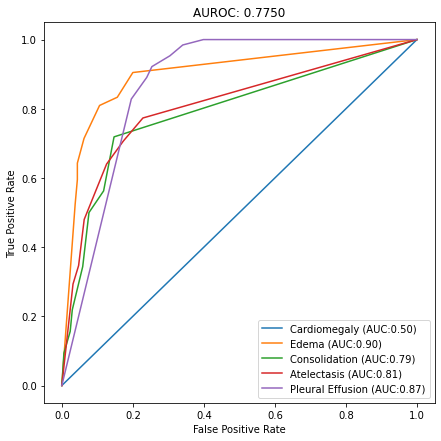

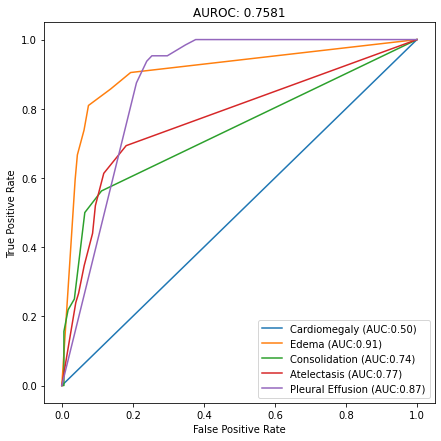

In [15]:
def plot_voting(predictions):
    from scipy.stats import entropy

    entropies = entropy([predictions,1-predictions],base = 2)

    binary_pred = predictions >= 0.2
    binary_pred = binary_pred.astype(int)
    final_pred = np.average(binary_pred,axis=0)
    final_pred = final_pred.astype(float)

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

    target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    results = pd.DataFrame()
    aurocs = []
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(score)
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results
plot_voting(test_predictions).to_csv('results/voting.csv')
plot_voting(tta_prediction_means).to_csv('results/voting_tta.csv')

# Single model performance


# Stacking

In [20]:
def build_meta_learner_dataset(models,dataset):
  predictions = []
  for model in models: 
    predictions.append(model.predict(dataset))
  predictions = np.array(predictions)
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))

  unbatched_dataset = dataset.unbatch()
  Y = []
  for _, labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y)
  return X , Y

def build_meta_learner_TTA_dataset(models, predictions, test_Y):
    new_pred = list()
    for i in range(predictions.shape[1]):
        new_pred.append(predictions[:,i])
    new_pred = np.array(new_pred)
    X = new_pred.reshape((new_pred.shape[0],-1))
    return X, test_Y

In [19]:
test_predictions.shape

(7, 202, 14)

In [21]:
train_X, train_Y= build_meta_learner_dataset(models,val_dataset)

In [26]:
test_X, test_Y = build_meta_learner_TTA_dataset(models, test_predictions, test_Y)
test_X_tta, test_Y_tta = build_meta_learner_TTA_dataset(models, tta_prediction_means, test_Y)

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(verbose=10,random_state=None, max_depth=30, max_features='sqrt', min_samples_split=5, n_estimators=1400)

In [46]:
rf.fit(train_X,train_Y.astype('int'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 1400
building tree 2 of 1400
building tree 3 of 1400
building tree 4 of 1400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


building tree 5 of 1400
building tree 6 of 1400
building tree 7 of 1400
building tree 8 of 1400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 1400
building tree 10 of 1400
building tree 11 of 1400
building tree 12 of 1400
building tree 13 of 1400
building tree 14 of 1400
building tree 15 of 1400
building tree 16 of 1400
building tree 17 of 1400
building tree 18 of 1400
building tree 19 of 1400
building tree 20 of 1400
building tree 21 of 1400
building tree 22 of 1400
building tree 23 of 1400
building tree 24 of 1400
building tree 25 of 1400
building tree 26 of 1400
building tree 27 of 1400
building tree 28 of 1400
building tree 29 of 1400
building tree 30 of 1400
building tree 31 of 1400
building tree 32 of 1400
building tree 33 of 1400
building tree 34 of 1400
building tree 35 of 1400
building tree 36 of 1400
building tree 37 of 1400
building tree 38 of 1400
building tree 39 of 1400
building tree 40 of 1400
building tree 41 of 1400
building tree 42 of 1400
building tree 43 of 1400
building tree 44 of 1400
building tree 45 of 1400
building tree 46 of 1400
building tree 47 of 1400
building tree 48 of 1400
b

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:  1.3min finished


RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=1400, verbose=10)

In [47]:
stacking_predictions = np.array(rf.predict_proba(test_X))[:,:,1].T
stacking_predictions_tta = np.array(rf.predict_proba(test_X_tta))[:,:,1].T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | el

In [41]:
stacking_predictions.shape

(202, 14)

STACKING RESULTS

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

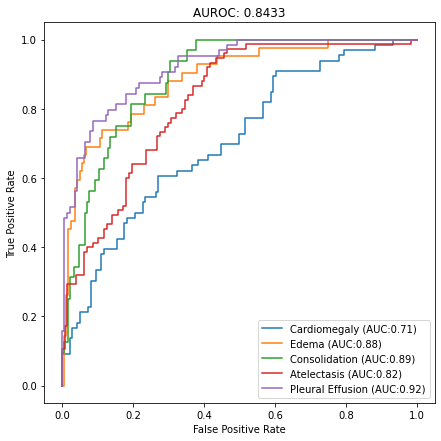

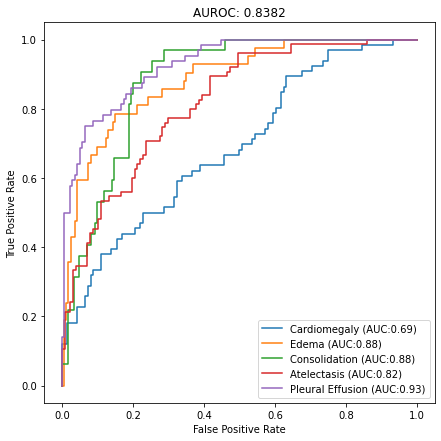

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_stacking(predictions):
    dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

    target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    results = pd.DataFrame()
    aurocs = []
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), predictions[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(score)
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results
plot_stacking(stacking_predictions).to_csv('results/stacking.csv')
plot_stacking(stacking_predictions_tta).to_csv('results/stacking_tta.csv')


# Embedding

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Models/densenet169_model.hdf5')

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = model.get_layer('global_average_pooling2d').output 
embedding_model = Model(inputs=model.input, outputs=x)

In [ ]:
def build_embedding_dataset(model,dataset):
  X = model.predict(dataset)
  
  unbatched_dataset = dataset.unbatch()
  Y = []
  for _,labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y).astype('int')  
  
  return X,Y

In [ ]:
val_X, val_Y = build_embedding_dataset(embedding_model,test_dataset)

In [ ]:
import pandas as pd 
path = '/content/drive/My Drive/Embedding/DenseNet121/validation_densenet121.csv'
df = pd.read_csv(path)

In [ ]:
val_X, val_Y = build_dataset(df)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [200,500,1000]
max_depth = [5, 15, 30]
min_samples_split = [2, 10, 50]
min_samples_leaf = [1, 5, 10] 
bootstrap = ['True','False']
max_features = ['sqrt','auto']


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier(verbose=10,random_state=42)

rf_random = RandomizedSearchCV(estimator = rf,n_iter = 100,
                               scoring='roc_auc', param_distributions= random_grid,
                               cv = 2,  n_jobs = -1,verbose=50)
rf_random.fit(val_X, val_Y.astype('int'))

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,verbose = 10 ,
                             bootstrap= True,max_depth = 30,
                             max_features= 'sqrt',
                             min_samples_leaf= 1,min_samples_split= 10,n_estimators= 200)


In [ ]:
rfc.fit(train_X,train_Y.astype(int))

In [ ]:
test_X, test_Y = build_embedding_dataset(embedding_model,test_dataset)

In [ ]:
predictions = rfc.predict_proba(test_X)
predictions = np.array(predictions)[:,:,1].T

# Embedding Ensemble

In [ ]:
def parse(x):
  return np.array(x.strip('][').split(', '),dtype=np.float32)
  
def build_dataset(df):
  df['Embedding'] = df['Embedding'].apply(lambda x: parse(x))
  values = df['Embedding'].values
  X = np.array([el for el in values])
  Y = df[df.columns[1:-1]].values
  return X, Y 

In [ ]:
import os
model_name = ['DenseNet121','DenseNet169','DenseNet201',
              'VGG16','VGG19','Xception','InceptionResNetV2']
embedding_base_path = 'EmbeddingTrained'
model_base_path = '/content/drive/My Drive/Embedding'

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=1FghuuMDHhpNIoEmYlUxMiAngowN3Emke

In [ ]:
from joblib import dump, load
import pandas as pd

def compute_conditional_predictions(predictions):
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]


predictions = []
for name in model_name:
    ##LOAD THE MODEL
    filename = 'embedding_rf_{}.joblib'.format(name.lower())
    model = load(os.path.join(embedding_base_path,filename))
    ##LOAD THE DATA
    dataset_name = 'test_{}.csv'.format(name.lower())

    dataset = pd.read_csv(os.path.join(model_base_path,name,dataset_name))
    test_X, _ = build_dataset(dataset)
    model_pred = model.predict_proba(test_X)
    model_pred = np.array(model_pred)[:,:,1].T
    compute_conditional_predictions(model_pred)
    predictions.append(model_pred)

final_predictions = np.array(predictions)

In [ ]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

**Ensemble of the 8 Random Forest**

In [ ]:
plot_result(test_Y,np.average(final_predictions,axis=0))

# Conditional Training

In [ ]:
def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
  base_path = '/content/drive/My Drive/tfrecords'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parsed_dataset = dataset.map(record_parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64
train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = NASNetMobile(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
for layer in model.layers[:-1]:
  layer.trainable = False

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/ConditionalTraining/NASNetMobile/PreTrained'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [ ]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=135mh_ET_e4eiupA-dgv_KaxOPd_RvyQ0

In [ ]:
from tensorflow.keras.models import load_model

model_names = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

models = []
for el in model_names:
  mod = load_model('ConditionalTraining/{}/FineTuning/model-05.hdf5'.format(el))
  models.append(mod)

In [ ]:
nn_predictions = []
for model in models:
  nn_predictions.append(compute_predictions(model))
nn_predictions = np.array(nn_predictions)

In [ ]:
plot_result(test_Y,np.average(nn_predictions,axis=0))

In [ ]:
from scipy.stats import entropy
nn_entropies = entropy([nn_predictions,1-nn_predictions],base = 2)
nn_pred = np.average(nn_predictions,axis=0, weights=1-nn_entropies)

In [ ]:
plot_result(test_Y,nn_pred)

In [ ]:
import pandas as pd 

def parse(x):
  return np.array(x.strip('][').split(', '),dtype=np.float32)
  
def build_dataset(df):
  df['Embedding'] = df['Embedding'].apply(lambda x: parse(x))
  values = df['Embedding'].values
  X = np.array([el for el in values])
  #Y = df[df.columns[1:-1]].values
  return X

# XGBoost

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=14GfK5ix7iwtFaRVnz5zXjLGGoT1I9e4v

In [ ]:
import xgboost as xgb
import os
import pandas as pd
model_name = ['DenseNet121','DenseNet169','DenseNet201',
              'VGG16','VGG19','Xception','InceptionResNetV2']
model_base_path = '/content/drive/My Drive/XGBoost'
embedding_base_path = '/content/drive/My Drive/Embedding'

predictions = []
for name in model_name:
  dataset_name = 'test_{}.csv'.format(name.lower())
  dataset = pd.read_csv(os.path.join(embedding_base_path,name,dataset_name))
  test_X = build_dataset(dataset)

  model_pred = []
  dtest = xgb.DMatrix(test_X)
  for i in range(14):
    filename = 'xgboost_lab_{}.joblib'.format(i)
    model = load(os.path.join(model_base_path,name,filename))
    model_pred.append(model.predict(dtest))

  predictions.append(np.array(model_pred).T)


In [ ]:
plot_result(test_Y,np.average(predictions,axis=0))

# Final Result

Link ai file contenenti le predizioni: https://drive.google.com/open?id=1746ztMAbqPrihRUWTuj5iOxcKn27zUQn

In [ ]:
import numpy as np
rf_predictions = np.load('/content/drive/My Drive/Predictions/nn_pred_no_entropy.npy')
nn_predictions = np.load('/content/drive/My Drive/Predictions/rf_pred_no_entropy.npy')
xgb_predictions = np.load('/content/drive/My Drive/Predictions/xgb_pred_no_entropy.npy')

In [ ]:
from scipy.stats import entropy
rf_entropies = entropy([rf_predictions,1-rf_predictions],base = 2)
nn_entropies = entropy([nn_predictions,1-nn_predictions],base = 2)
xgb_entropies = entropy([xgb_predictions,1-xgb_predictions],base = 2)

In [ ]:
rf_pred = np.average(rf_predictions,axis=0, weights=1-rf_entropies)
nn_pred = np.average(nn_predictions,axis=0, weights=1-nn_entropies)
xgb_pred = np.average(xgb_predictions,axis=0,weights=1-xgb_entropies)

In [ ]:
final_predictions = np.average([rf_pred,nn_pred,xgb_pred],axis=0)

In [ ]:
plot_result(test_Y,final_predictions)

In [ ]:
fin_pred = np.load('/content/drive/My Drive/Predictions/final_predictions.npy')
thresholds = np.load('/content/drive/My Drive/Predictions/thresholds.npy')

for i in range(fin_pred.shape[1]):
  threshold = thresholds[i]
  negative_label = (np.logical_and(fin_pred[:,i] >=0, fin_pred[:,i] <threshold-0.15*threshold))
  uncertain = (np.logical_and(fin_pred[:,i]>=threshold-0.15*threshold, fin_pred[:,i]<=threshold+0.15*threshold))
  positive_label = (np.logical_and(fin_pred[:,i]>=threshold+0.15*threshold, fin_pred[:,i]<=1))
  fin_pred[:,i][negative_label] = 0
  fin_pred[:,i][uncertain] = -1
  fin_pred[:,i][positive_label] = 1


In [ ]:
def compute_confusion_matrix(true_labels,predicted_labels):
  tp = 0 
  tn = 0 
  fp = 0 
  fn = 0 
  uncertain = 0 
  for true,predicted in zip(true_labels,predicted_labels):
    if predicted == -1:
      uncertain += 1
    if true == 1 and predicted == 1:
      tp += 1
    if true == 0 and predicted == 0:
      tn += 1
    if true == 0 and predicted == 1:
      fp +=1
    if true == 1 and predicted == 0:
      fn +=1
  return np.array([[tp,fn],[fp,tn]]),uncertain



In [ ]:
import seaborn as sns

idxs = [2,5,6,8,10]
label_name = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

for i in idxs:
  cm, uncertain = compute_confusion_matrix(test_Y[:,i],fin_pred[:,i])
  fig = plt.figure(figsize=(5,5))
  sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',cbar = False,yticklabels=[1,0],xticklabels=[1,0])
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title('{}'.format(label_name[i]))
  plt.show()
  spec = cm[1][1] / (cm[1][1] + cm[1][0])
  sensib = cm[0][0] / (cm[0][0] + cm[0][1])
  prec = cm[0][0] / (cm[0][0] + cm[1][0])
  f1 = (2*prec*sensib)/(prec+sensib)
  print('Uncertain labels: {}'.format(uncertain))
 